In [296]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import numpy
import sys
import codecs
import operator
import pymorphy2
#from pymorphy2 import MorphAnalyzer
import datetime
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import re

In [16]:
#Read text from csv as dataframe
import pandas
petitions = pandas.read_csv('C:\\Users\\Olha\\Desktop\\TARTU\\_Hackathons\\Int20h\\petitions_data_with_text.csv', encoding='utf-8')

In [36]:
#names of columns
petitions.columns

Index(['Unnamed: 0', 'author', 'start_date', 'status', 'number_of_votes',
       'number_of_necessary_votes', 'end_date', 'name', 'url', 'text'],
      dtype='object')

In [38]:
#example of one row - one petition
petitions.values[1]

array([1, 'Повзик Ігор Володимирович', '2015-10-04 12:37:27',
       'Підписання завершено (недостатньо підписів)', 494, 10000,
       '2016-01-31 20:06:43',
       'Повністю реконструювати Шулявську розв&#039;язку',
       'https://petition.kievcity.gov.ua/petition/?pid=3',
       'Це питання не вирішується роками.\r\n Розв&rsquo;язка дуже незручна для водіїв. Міст скоро впаде на голови пішоходів. Процвітає стихійна торгівля. \r\n\r\n p.s. (як приклад проект Віктора Петрука) '], dtype=object)

In [37]:
#number of petitions
print(len(petitions))

4536


In [193]:
#number of non-successful/successful petitions
non_success_ids = []
success_ids = []

for i in range(len(petitions)):
    bigger = 0
    now = datetime.now()
    date_end = datetime.strptime(petitions['end_date'].values[i], '%Y-%m-%d %H:%M:%S')
    date_begin = datetime.strptime(petitions['start_date'].values[i], '%Y-%m-%d %H:%M:%S')
    middle = date_begin + (date_end - date_begin)/2
    if '(недостатньо підписів)' in petitions['status'].values[i]:
        non_success_ids.append(i)
    elif '(достатньо підписів)' in petitions['status'].values[i]:
        success_ids.append(i)
    elif "На підписанні" in petitions['status'].values[i]:
        if petitions['number_of_votes'].values[i] >= petitions['number_of_necessary_votes'].values[i]/2 and now <= middle: 
            success_ids.append(i)
        else: 
            non_success_ids.append(i)
    else:
        print('Unusual status:', petitions['status'].values[i])
print("Number of successful petitions:", len(success_ids))
print("Number of not successful petitions:", len(non_success_ids))
print(len(non_success_ids) + len(success_ids))

Number of successful petitions: 46
Number of not successful petitions: 4490
4536


In [71]:
#percenteges for successful petitions

success_perc = {}
for i in success_ids:
    success_perc[i] = round(petitions['number_of_votes'].values[i]/petitions['number_of_necessary_votes'].values[i], 4)
#print(sorted(success_perc.values()))

In [115]:
general_good = []
for i in success_ids:
    general_good.append(petitions['text'].values[i])
    
general_bad = []
for i in non_success_ids:
    general_bad.append(petitions['text'].values[i])

In [116]:
def clean(text):
    for i in range(len(text)):
        text[i] = text[i].replace('&rsquo;', "'")        
        text[i] = text[i].replace("\'", "'")
        text[i] = text[i].replace('&#039;', "'")
        text[i] = text[i].replace('\n', '')
        text[i] = text[i].replace('\n&bull;', '')
        text[i] = text[i].replace('\r', '')
        text[i] = text[i].replace('&amp;', '&')
        text[i] = text[i].replace('&laquo;', '"')
        text[i] = text[i].replace('&copy;', '')
        text[i] = text[i].replace('&mdash;', '-')    
        text[i] = text[i].replace('&ndash;', '-')
        text[i] = text[i].replace('&raquo;', '"')
clean(general_good)
clean(general_bad)

In [134]:
def numeric(text):
    #sentences, words and word types
    words = []
    sents = []
    for i in range(len(text)):
        words += word_tokenize(text[i])
        sents += sent_tokenize(text[i])

    nwords = len(words)
    nsents = len(sents)
    nwtypes = len(list(set(words)))

    print("Number of words: ", nwords)
    print("Number of sentences: ", nsents)
    print("Number of unique words: ", nwtypes)

    #The average length of the sentences
    lens = []
    for i in range (0, nsents):
        lens.append(len(sents[i]))
    avg_sent_length = numpy.mean(lens)

    #The average length of the words
    distinct_word_lengths = []    
    for i in range (0, nwords):
        distinct_word_lengths.append(len(words[i]))
    avg_word_length = numpy.mean(distinct_word_lengths)
    
    avg_sents = round(avg_sent_length/avg_word_length)
    avg_words = round(avg_word_length)

    print("The average number of words in sentences: ", avg_sents)
    print("The average lenght of words: ", avg_words)
    
    return words, nwords, nsents, nwtypes, lens, avg_sents, distinct_word_lengths, avg_words

print("In successful petitions:")
words_good, nwords_good, nsents_good, nwtypes_good, lens_good, avg_sents_good, distinct_word_lengths_good, avg_words_good = numeric(general_good)
print("In non successful petitions:")
words_bad, nwords_bad, nsents_bad, nwtypes_bad, lens_bad, avg_sents_bad, distinct_word_lengths_bad, avg_words_bad = numeric(general_bad)

In successful petitions:
Number of words:  8956
Number of sentences:  318
Number of unique words:  4092
The average number of words in sentences:  32.0
The average lenght of words:  6.0
In non successful petitions:
Number of words:  512168
Number of sentences:  22746
Number of unique words:  77523
The average number of words in sentences:  26.0
The average lenght of words:  5.0


In [135]:
#statistic hypotesis
from scipy.stats import ttest_ind

print(ttest_ind(lens_good, lens_bad))
#result: good petitions have bigger lenght of sentences than bad ones

print(ttest_ind(distinct_word_lengths_good, distinct_word_lengths_bad))
#result: good petitions have bigger lenght of words than bad ones

Ttest_indResult(statistic=5.170691673606739, pvalue=2.3517623150655901e-07)
Ttest_indResult(statistic=5.999977391879864, pvalue=1.9747447390123618e-09)


In [244]:
def exclamation(text):
    counter_exclamation = 0
    i = 1
    while i < len(text):
        if text[i] == '!' and text[i-1] == "!":
            counter_exclamation += 1
            i += 2
        else:
            i += 1
    return counter_exclamation

counter_exclamation_good = exclamation(words_good)
print("Number of 'extra !' in text of good petitions: ", counter_exclamation_good)
counter_exclamation_bad = exclamation(words_bad)
print("Number of 'extra !' in text of bad petitions: ", counter_exclamation_bad)
print("Number of 'extra !' in text of good petitions per sentences: ", counter_exclamation_good/nsents_good)
print("Number of 'extra !' in text of bad petitions per sentences: ", counter_exclamation_bad/nsents_bad)
#number of ! don't influent on petition success

Number of 'extra !' in text of good petitions:  8
Number of 'extra !' in text of bad petitions:  530
Number of 'extra !' in text of good petitions per sentences:  0.025157232704402517
Number of 'extra !' in text of bad petitions per sentences:  0.023300800140684075


In [310]:
def frequency_words(words):
    d = dict()
    #filtering
    sign = [',', '.', '-', '!', '?', ':', ';', '...', '''''' , '``', '..', '*', '—', '\'\'', '’', ')', '(', '|']
    cleaned_words = [word for word in words if word not in sign]
    
    #stemmatization
    stemmer_ = nltk.SnowballStemmer('russian')
    stemmed_words = []
    for w in cleaned_words:
        stemmed_words.append(stemmer_.stem(w))

    #delete stopwords
    with codecs.open('C:\\Users\\Olha\\Desktop\\TARTU\\_Hackathons\\Int20h\\stop_ukr.txt',encoding='cp1251') as ins:
        stop_words = ins.read()
    without_stop = [word for word in stemmed_words if word not in stop_words and len(word)>3]
    
    for i in range(len(without_stop)):
        st = without_stop[i]
        st = re.sub(r'<[^>]+>', r'',st).strip() # HTML tags
        st = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', r'',st).strip()  # URLs 
        st = re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)', r'',st).strip() # numbers
        without_stop[i] = st
        
    for w in without_stop:
        if w in d.keys():
            d[w] += 1
        else:
            d[w] = 1
    a = Counter(d)
    b = a.most_common(100)
    return without_stop, b

text_good, dict_good = frequency_words(words_good)
text_bad, dict_bad = frequency_words(words_bad)

The most frequent words in successful petitions


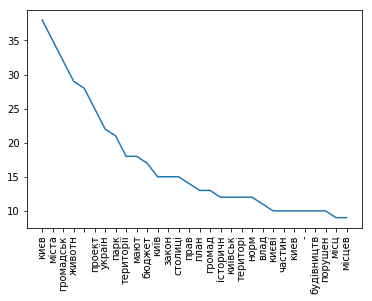

The most frequent words in not successful petitions


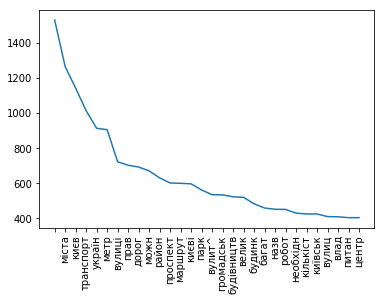

In [311]:
def plot_popular(text):
    plt.xticks(numpy.arange(len([k for k in text])), [k[0] for k in text], rotation = 90)
    plt.plot(numpy.arange(len([k for k in text])), [k[1] for k in text])
    plt.show()
print("The most frequent words in successful petitions")
plot_popular(dict_good[:30])
print("The most frequent words in not successful petitions")
plot_popular(dict_bad[:30])

In [307]:
with open("C:\\Users\\Olha\\Desktop\\TARTU\\_Hackathons\\Int20h\\bad.txt", "w", encoding='utf-8') as f:
    for i in range(len(text_bad)):
        f.write(text_bad[i].lower() + " ")
with open("C:\\Users\\Olha\\Desktop\\TARTU\\_Hackathons\\Int20h\\good.txt", "w", encoding='utf-8') as f:
    for i in range(len(text_good)):
        f.write(text_good[i].lower() + " ")